In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.util.sample_factory as sf
import pofah.jet_sample as js
import pofah.util.utility_fun as utfu
import pofah.util.experiment as exp

import pathlib
import argparse
from typing import List

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
from typing import List

Welcome to JupyROOT 6.18/04


## run config params

In [27]:
ae_run_n = 113
qr_run_n, qr_model_str = 4, 'poly'
#qr_run_n, qr_model_str = 5, 'bernstein'
xsec = 0
mX = 3.5
sample_ids = ['qcdSigAllTestReco', 'GtoWW35naReco']
sample_id_qcd = sample_ids[0]
#quantiles = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
quantiles = [0.3, 0.5, 0.7, 0.9, 0.99]
#quantiles = [0.1, 0.5, 0.99]
path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_ids[1], 'xsec': str(int(xsec)), 'loss': 'rk5_05'}

# choose which template quantile to use (0 = 0.9-1.0, 1 = 0.7-0.9)
template_q_idx = 0
# Set binning
dijet_bin = True

## read in data

In [28]:
paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
paths.extend_in_path_data(path_ext_dict)
paths.extend_out_path_data({**path_ext_dict, 'mjj_spectra': None, 'orthogonal': None})

samples = {}

for sample_id in sample_ids:
    samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id))

In [29]:
samples_ortho_quantiles = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles)

mjj_vals = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles]

In [30]:
quantiles_inv = [round((1.-q),2) for q in [0]+quantiles+[1.]] # invert quantiles to [1.0 0.9, 0.7, 0.5, 0.3, 0.1, 0.01]
q_str = [str(q) for q in quantiles_inv]

In [31]:
quantiles_inv

[1.0, 0.7, 0.5, 0.3, 0.1, 0.01, 0.0]

In [32]:
len(mjj_vals)

6

In [33]:
num_samples = sum(map(len,mjj_vals))
print(num_samples)

7671759


In [34]:
# Dijet variable-binwidth binning (depends on dijet resolution)
if dijet_bin:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327]).astype('float')
                          #5574, 5737, 5951, 6173, 6402, 6638, 6882]).astype('float')

# Constant binwidth
else:
    bin_edges = np.array(np.arange(1200.,6800., 50.).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800


n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [35]:
cmap = cm.get_cmap('winter')
cmap = [mpl.colors.rgb2hex(c) for c in cmap(np.linspace(0.0, 1.0, len(mjj_vals)+1))][1:]

## read data into histograms

In [36]:
n_bins = len(bin_edges)-1 #50
#min_bin = min([np.min(mjj) for mjj in mjj_vals])
#max_bin = max([np.max(mjj) for mjj in mjj_vals])
hist_sz = 700
marker_sty = 8
marker_sz = 0.9

In [37]:
# template / bottom histogram
props={'LineColor': rt.kBlack, "YTitle": 'num events', "XTitle": "M_{jj} [GeV]", "Title":"", "Minimum": 0.2, "Maximum": num_samples*1.1}
ht = rpu.create_hist(mjj_vals[template_q_idx],'',n_bins, bin_edges.astype('float'), props=props)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [38]:
quantiles_inv

[1.0, 0.7, 0.5, 0.3, 0.1, 0.01, 0.0]

In [39]:
# other ortho quantile hists
hh = []
for mjj,c in zip(mjj_vals[template_q_idx+1:], cmap[template_q_idx:]):
    props = {"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "LineWidth": 1, "MarkerStyle": marker_sty, "MarkerSize": marker_sz}
    h = rpu.create_hist(mjj, '', n_bins, bin_edges.astype('float'), props=props)
    hh.append(h)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [40]:
len(hh)

5

In [41]:
# create ratio histograms
hr = []
for h, c in zip(hh, cmap[template_q_idx:]):
    props={"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "Title": '', "LineWidth": 1, "MarkerStyle": marker_sty}
    r = rpu.create_ratio_hist(h,ht,props=props)
    hr.append(r)
rpu.set_style(hr[0], props={ "XTitle": 'M_{jj} [GeV]', "YTitle": "ratio SIG / BG"})

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


## draw figure

In [42]:
import cmsstyle #mplhep for Python2 cheatsheet
c_out, pad1, pad2 = rpu.create_canvas_pads(pad_props={'LeftMargin': 0.13})
# legend
leg = rpu.create_object("TLegend", 0.62, 0.5, 0.85, 0.78)
leg_h = rpu.create_object("TLegend", 0.4, 0.8, 0.95, 0.85) # second legend for header because left align not available
rpu.set_style(leg,props={'TextSize': 0.045})
rpu.set_style(leg_h,props={'TextSize': 0.045})

In [43]:
pad1.cd()
# draw template histogram
ht.Draw('HIST')
rpu.set_style(ht.GetYaxis(), props={'TitleSize':0.05, 'LabelSize':0.05, 'TitleOffset':0.95, 'Ndivisions':304})
leg.AddEntry(ht, 'q = '+q_str[template_q_idx+1]+'-'+q_str[template_q_idx], 'lep')

<ROOT.TLegendEntry object ("TLegendEntry") at 0x787c8a0>

In [44]:
# draw remaining histograms
for h in hh:
    h.Draw('pez same')
ht.Draw('hist same') # draw once more on top

In [45]:
for h, qi, qii in zip(hh, q_str[template_q_idx+2:], q_str[template_q_idx+1:]):
    leg.AddEntry(h, 'q = {} - {}'.format(qi,qii), 'lep')

leg_h.SetHeader(r'Data: QCD MC + G_{RS}(%.1fTeV,#sigma=%i fb)'%(mX,xsec))
leg.Draw()
leg_h.Draw()

In [1]:
pad2.cd()
hr[0].Draw('pe')
props={'YTitle':'#frac{#epsilon#timesq}{q_{0.9-1.0}}', 'XTitle':'M_{jj} (GeV)', 'Maximum':1.7, 'Minimum':0.3, 'TitleOffset':0.4}
rpu.set_style(hr[0],props=props)
rpu.set_style(hr[0].GetYaxis(),props={'TitleSize':0.12, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.4 })
rpu.set_style(hr[0].GetXaxis(),props={'TitleSize':0.12, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.95, 'Ndivisions':909, 'TickSize':0.07 })
hr[0].GetYaxis().CenterTitle()

for r in hr[1:]:
    r.Draw('pe same')

NameError: name 'pad2' is not defined

In [47]:
eff_line = rpu.create_ratio_line(hr[0])
eff_line.Draw('same')

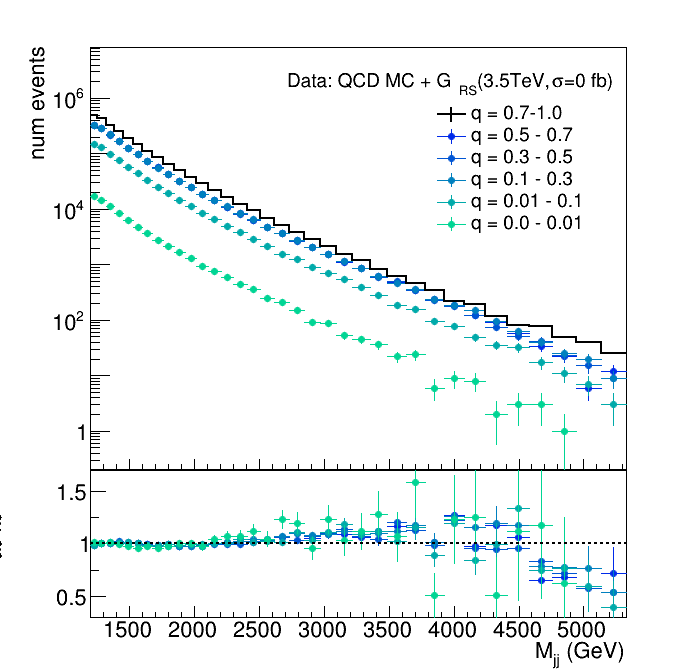

In [48]:
c_out.Draw()

In [49]:
template_str = ('q'+q_str[template_q_idx+1]+'_q'+q_str[template_q_idx]).replace('.', '')
c_out.SaveAs('fig/mjj_ratio_xsec0_{}_{}_binning_{}_template.pdf'.format(qr_model_str, 'dijet' if dijet_bin else 'linspace', template_str))

Info in <TCanvas::Print>: pdf file fig/mjj_ratio_xsec0_poly_dijet_binning_q07_q10_template.pdf has been created
